<h1><center>PISAP: Python Interactive Sparse Astronomical Data Analysis Packages</center></h1>
<h2><center>Anstronomic/Neuroimaging denoising tutorial</center></h2>
<div style="text-align: center">Credit: </div>

Pisap is a Python package related to sparsity and its application in
astronomical or mediacal data analysis. This package propose sparse denosing methods reusable in various contexts.
For more information please visit the project page on github: https://github.com/neurospin/pisap.<br><br>

<h3>First check</h3>

In order to test if the 'pisap' package is installed on your machine, you can check the package version:

In [1]:
import pisap
print pisap.__version__

0.0.0


<h2>The Condat-Vu primal dual sparse denoising with reweightings</h2>

The package provides a flexible implementation of the Condat-Vu denoising algorithm that can be reused is various contexts. In this tutorial we will apply this denoising method on two toy astronomical and neuroimaging toy dataset respectivelly.

<h3>Astronomical denoising</h3>

First load the toy datase and the associated sampling mask.

In [2]:
import scipy.fftpack as pfft
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from pisap.data import get_sample_data
from pisap.base.utils import convert_mask_to_locations
from pisap.numerics.noise import add_noise
from pisap.numerics.reconstruct import sparse_rec_fista
from pisap.numerics.gradient import Grad2DSynthesis
from pisap.numerics.linear import Wavelet
from pisap.numerics.fourier import FFT
from pisap.numerics.cost import snr, nrmse

In [3]:
fits_data_path = get_sample_data("astro-fits")
image = pisap.io.load(fits_data_path)
image.show()
mask_data_path = get_sample_data("astro-mask")
mask = pisap.io.load(mask_data_path)
mask.show()

Now generate a synthetic image from the previous toy_dataset and sampling mask.

In [4]:
dirty_data = add_noise(image.data, sigma=0.01, noise_type="gauss")
dirty_image = pisap.Image(data=dirty_data)
dirty_image.show()
mask_shift = pfft.ifftshift(mask.data)
localization = convert_mask_to_locations(mask_shift)
dirty_fft = mask_shift * pfft.fft2(dirty_image.data)

Now run the denoising algoritm with custom gradient and linear operator using a positivity constraint.

In [5]:
metrics = {'snr':{'metric':snr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': True,
                   },
            'nrmse':{'metric':nrmse,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': False,
                   },
           }
params = {
    'data':dirty_fft,
    'gradient_cls':Grad2DSynthesis,
    'gradient_kwargs':{"ft_cls": {FFT: {"samples_locations": localization,
                                        "img_size": dirty_fft.shape[0]}}},
    'linear_cls':Wavelet,
    'linear_kwargs':{"nb_scale": 3, "wavelet": "MallatWaveletTransform79Filters"},
    'max_nb_of_iter':100,
    'mu':2.0e-2,
    'metrics':metrics,
    'verbose':1,
}

x, y, saved_metrics = sparse_rec_fista(**params)

Starting FISTA reconstruction algorithm.
 - mu:  0.02
 - lipschitz_cst:  1.09999993443
--------------------


-------> early-stopping done


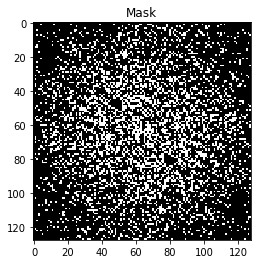

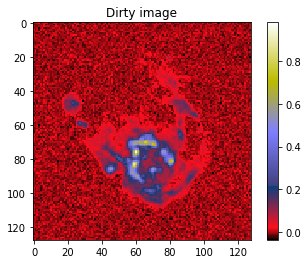

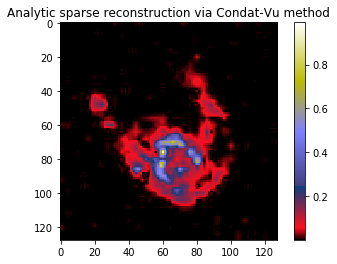

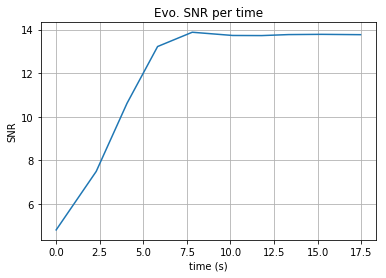

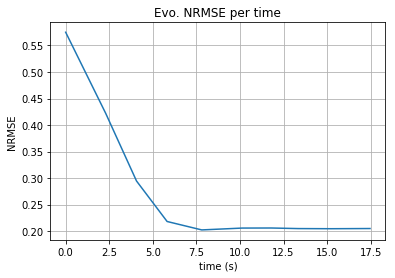

In [6]:
plt.figure()
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.figure()
plt.imshow(dirty_image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Dirty image")

plt.figure()
plt.imshow(np.abs(x.data), interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Analytic sparse reconstruction via Condat-Vu method")

metric = saved_metrics['snr']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("SNR")
plt.title("Evo. SNR per time")

metric = saved_metrics['nrmse']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("NRMSE")
plt.title("Evo. NRMSE per time")

plt.show()

<h3>Neuroimagin denoising</h3>

First load the toy datase and the associated sampling mask.

In [7]:
fits_data_path = get_sample_data("mri-slice-nifti")
image = pisap.io.load(fits_data_path)
image.show()
mask_data_path = get_sample_data("mri-mask")
mask = pisap.io.load(mask_data_path)
mask.show()
mask_shift = pfft.ifftshift(mask.data)

Now generate a synthetic image from the previous toy_dataset and sampling mask.

In [8]:
dirty_data = add_noise(image.data, sigma=0.01, noise_type="gauss")
dirty_image = pisap.Image(data=dirty_data)
dirty_image.show()
localization = convert_mask_to_locations(mask_shift)
dirty_fft = mask_shift * pfft.fft2(dirty_image.data)

Now run the denoising algoritm with custom gradient and linear operator using a positivity constraint.

In [9]:
metrics = {'snr':{'metric':snr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': True,
                   },
            'nrmse':{'metric':nrmse,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': False,
                   },
           }
params = {
    'data':dirty_fft,
    'gradient_cls':Grad2DSynthesis,
    'gradient_kwargs':{"ft_cls": {FFT: {"samples_locations": localization,
                                        "img_size": dirty_fft.shape[0]}}},
    'linear_cls':Wavelet,
    'linear_kwargs':{"nb_scale":5, "wavelet": "MallatWaveletTransform79Filters"},
    'max_nb_of_iter':100,
    'mu':4.5e-2,
    'metrics':metrics,
    'verbose':1,
}

x, y, saved_metrics = sparse_rec_fista(**params)

Starting FISTA reconstruction algorithm.
 - mu:  0.045
 - lipschitz_cst:  1.1
--------------------


100% |########################################################################|


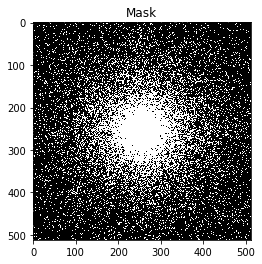

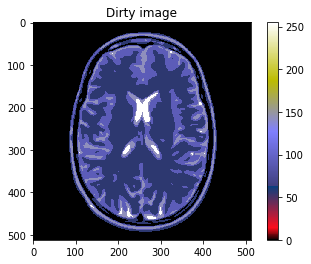

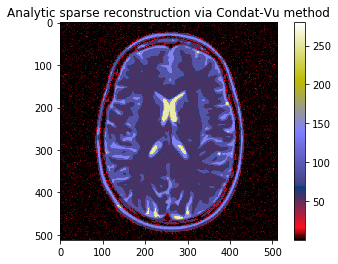

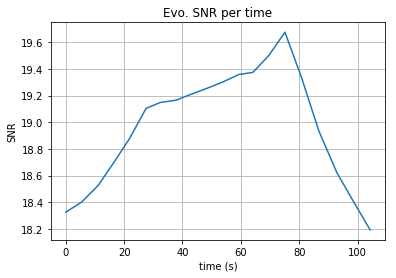

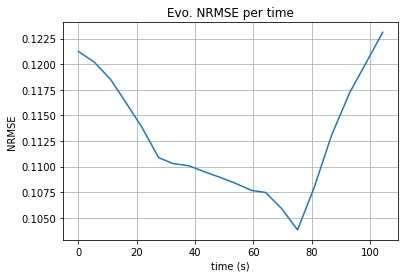

In [10]:
plt.figure()
plt.imshow(np.real(mask), cmap='gray')
plt.title("Mask")

plt.figure()
plt.imshow(dirty_image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Dirty image")

plt.figure()
plt.imshow(np.abs(x.data), interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Analytic sparse reconstruction via Condat-Vu method")

metric = saved_metrics['snr']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("SNR")
plt.title("Evo. SNR per time")

metric = saved_metrics['nrmse']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("NRMSE")
plt.title("Evo. NRMSE per time")

plt.show()